## Global Terrorist Attacks 

__Data__: [GTD](https://www.start.umd.edu/gtd/) (Golbal Terrorism Database) is an open-source data base, containing information about over 180,000 terrorist attacks that were recorded from 1970 to 2017, including features such as date/time, location, attack type, responsible group (if identified), target type, weapon type, and fatalities/injuries.  

__Motivation & Goal__: Prediction of terrorist group after an attack is one of the
most important steps for counter terrorism. As soon as we are able to find the involved group name, we will be able to make strategies to catch the culprits. 
The goal of this project is to build a classifier that can classify the Perpetrator Groups based on the 135 features provided. 82782 among 181691 attacks have unknown terrorist groups. There are in total 3536 different identified terror groups, and they normally work individually, only 0.03241 collaborate with other groups ((df['gsubname'].notnull()).sum()/181691). 

__Models__: Classify those groups based on the country, location, targettype, weapon etc information. Classification models: Tree models, KNN, and Neutral Network. Tree models are insensive to the imbalanced dataset.    

__Evaluation Metrics__: Accuracy Score is the percentage number of
correctly classified instances (the number of correct
predictions from all predictions made).; F1-Score, the balance between precision and recall.  


In [1]:
import pandas as pd
import numpy as np
from pylab import *
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter
from glob import glob
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from mpl_toolkits.basemap import Basemap
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
rc('axes', linewidth=3)
from matplotlib import animation,rc
from IPython.display import HTML
rc('animation', html='html5')
import io
import base64

In [3]:
df = pd.read_excel('globalterrorismdb_0718dist.xlsx')
print('Total Data Shape',df.shape)
df.head(1)

Total Data Shape (181691, 135)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN


### Feature Exploration 

135 features are recorded in the dataset, for detailed explaination of these features and how the data was collected, go to the [cookbook](http://apps.start.umd.edu/gtd/downloads/dataset/Codebook.pdf).

__Steps__:
- Check the missing features. 
- Features visulazation.
 - __Fig1__. The overall increase of the number of attacks over years. 
 Animation: Geolocation change with years.  
 - __Fig2__. The number of terrorist attacks differs by regions. About ~52% attacks happened at Middle East, North Africa, and South Asia area. 
 - __Fig3__. Different attack methods. 
 - __Fig4__. The top 20 most active terrorist groups. 
 - __Fig5__. Geolocation of different terrorist groups. 
 - __Fig6__. Top 10 active terrorist groups vs target types & attack types.
 - __Fig7__. The casulaities and value of damage of top 10 active groups. 
 - __Fig8__. The casulaities and value of damage based on the targets of terrorist attacks. 
 - __WordCloud__. of the motivation of attacks

In [4]:
# drop if the feature has too many NaNs or low variance 
class CheckData:
    # class to check if the features have too many missing values 
    #or low variance across the dataset
    def __init__(self,df,length,ratio):
        self.df = df 
        self.len = length
        self.ratio = ratio
    def drop_col_NaN(self):
        N = (pd.isnull(self.df).sum().sort_values(ascending=False)/self.len > self.ratio).sum()
        nan=pd.isnull(self.df).sum().sort_values(ascending=False).head(N) 
        # drop if too many NaNs (>95%)
        dropcol=[col for col in nan.axes[0]]
        # if too many zeros
        for col in self.df.columns:   
            if self.df[col].dtype==np.int64:
                if (self.df[col]==0).sum() >=self.len*self.ratio:
                    dropcol.append(col)
            if self.df[col].dtypes == np.object:
                if 'txt' in col:
                    dropcol.append(col)
                a=self.df.groupby(col).count()
                if a['eventid'].max()>=self.len*self.ratio:  # which means 90% of the information are the same 
                    dropcol.append(col)
        return dropcol    

In [5]:
dropcol = CheckData(df,181691,0.90).drop_col_NaN()

In [6]:
# kill + wound 
df['casualities'] = df['nkill']+df['nwound'] # create a new feature 
print('sucess of all the attacks',df['success'].sum()/181691)
df['propvalue'] = df['propvalue'].replace(-99,0).fillna(0)
df['nkill'] = df['nkill'].fillna(0)
df['nwound'] = df['nwound'].fillna(0)

sucess of all the attacks 0.8895982739926579


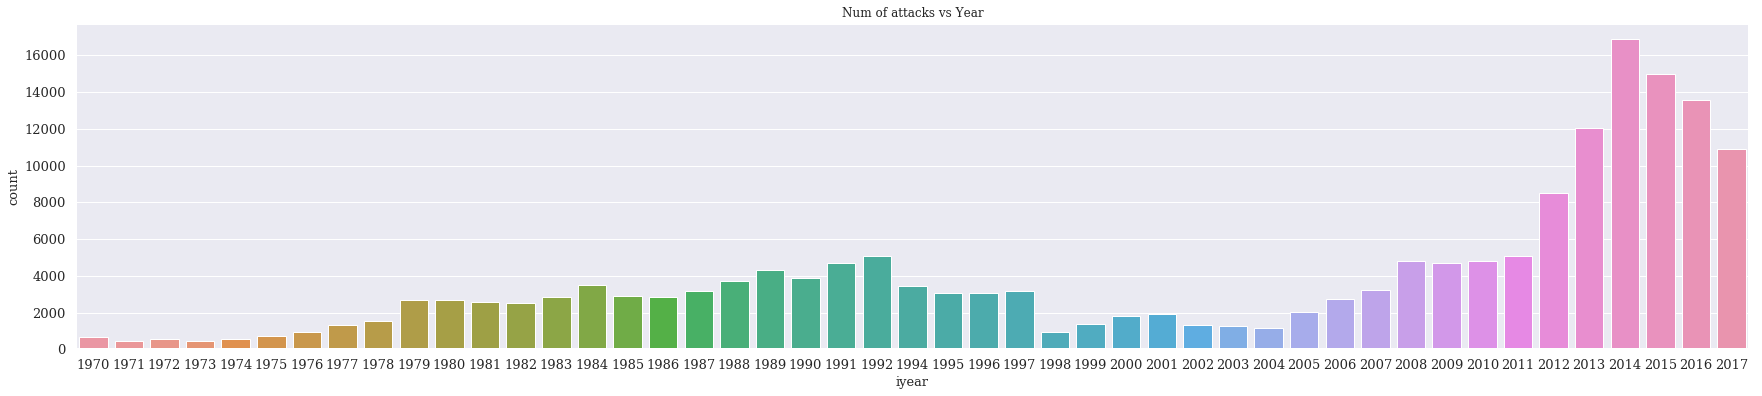

In [7]:
fig = plt.figure(figsize=(30,6))
g=sns.countplot(x='iyear',data=df)
g.set_title('Num of attacks vs Year') 


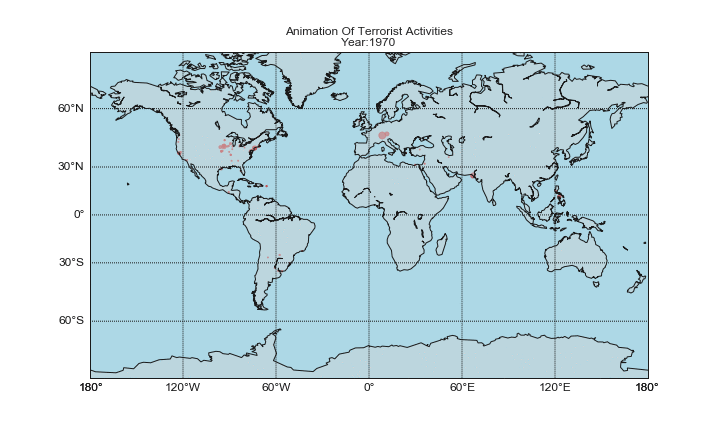

In [8]:
fig = plt.figure(figsize = (10,6))   
    
def animate(Year):
    ax = plt.axes()
    ax.clear()
    ax.set_title('Animation Of Terrorist Activities'+'\n'+'Year:' +str(Year))
    m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
    lat=list(df[df['iyear']==Year].latitude.astype("float"))
    long=list(df[df['iyear']==Year].longitude.astype("float"))
    x,y=m(long,lat)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
    m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])
    # fill continents 'coral' (with zorder=0), color wet areas 'aqua'
    m.drawmapboundary(fill_color='lightblue')
    m.fillcontinents(color='lightgrey',lake_color='lightblue',zorder=1,alpha=0.4)
    m.scatter(x, y,s=[c for c in df[df['iyear']==Year].casualities],\
              color = 'r',alpha = .7)

    
#ani = animation.FuncAnimation(fig,animate,list(df['iyear'].unique()), interval = 1500)    
#ani.save('animation.gif', writer='imagemagick', fps=1)
#plt.close(1)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

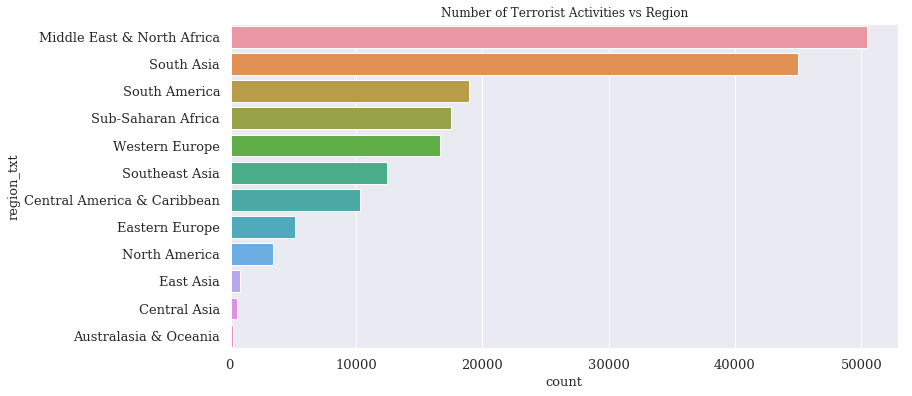

In [9]:
fig = plt.figure(figsize=(12,6))
g=sns.countplot(y='region_txt',data=df,order=df['region_txt'].value_counts().index)
g.set_title('Number of Terrorist Activities vs Region') 

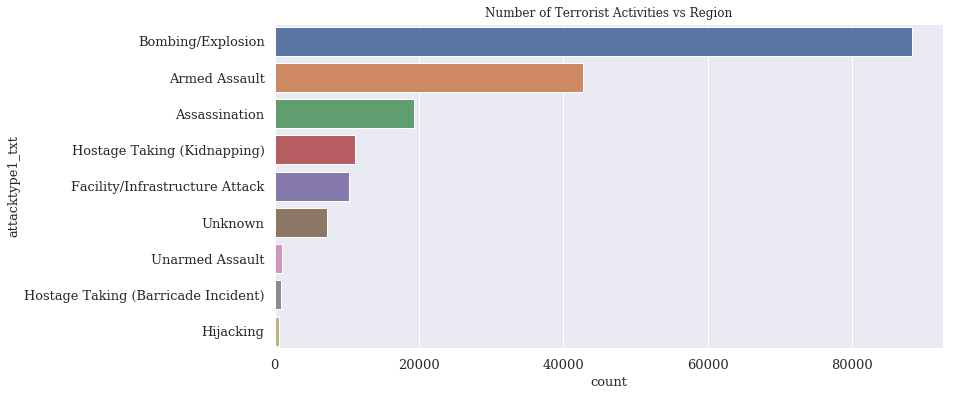

In [10]:
fig = plt.figure(figsize=(12,6))
g=sns.countplot(y='attacktype1_txt',data=df,order=df['attacktype1_txt'].value_counts().index)
g.set_title('Number of Terrorist Activities vs Region') 

__Terror Groups__:
[US National Security](https://brat.house.gov/news/documentsingle.aspx?DocumentID=227) released the Top 10 Most Dangerous Terrorist Groups. 
1. Islamic State (ISIS)
2. Al-Qaeda 
3. Taliban (partnered with al-Qaeda)
4. Tehrik-i-Taliban Pakistan
5. Boko Haram (now pledged to ISIS)
6. al-Nusra Front (a branch of al-Qaeda) 
7. Hezbollah
8. Hamas (a sub-group from the Muslim Brotherhood)
9. Kurdistan Worker’s Party (PKK)
10. Revolutionary Armed Forces of Colombia (the FARC)

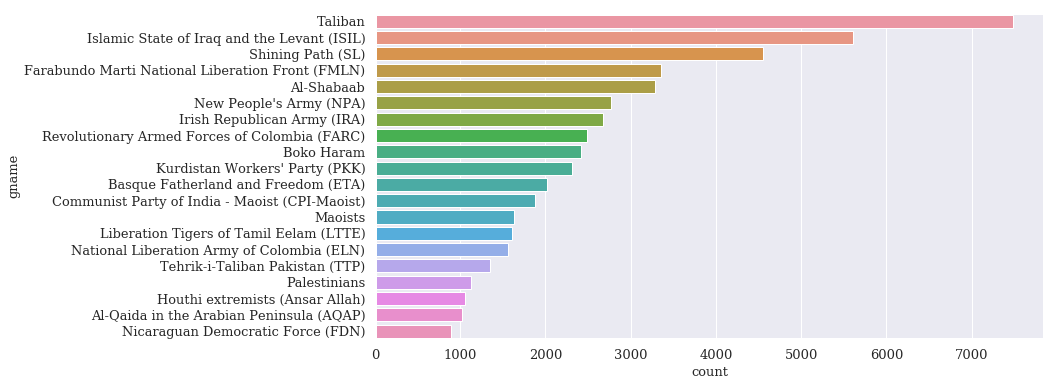

In [11]:
fig = plt.figure(figsize=(12,6))
num = 20
sns.countplot(y=df['gname'],\
              order = df[df['gname'] !='Unknown']['gname'].value_counts().iloc[:num].index)

In [12]:
terror_groups_20 = df.groupby('gname')['eventid'].count().nlargest(20).keys()[1:] 
#drop the unknown #terror_groups
terror_groups_10 = df.groupby('gname')['eventid'].count().nlargest(10).keys()[1:] 

In [14]:
terror_10 = df[df['gname'].isin(terror_groups_10)]
group_categories = ['Taliban', 'ISIL','SL', 'FMLN','Al-Shabaab', 'NPA', 'IRA','FARC', 'Boko Haram']
code = {x:y for x, y in zip(terror_groups_10,group_categories)}
terror_10['gname'] = terror_10['gname'].map(code)

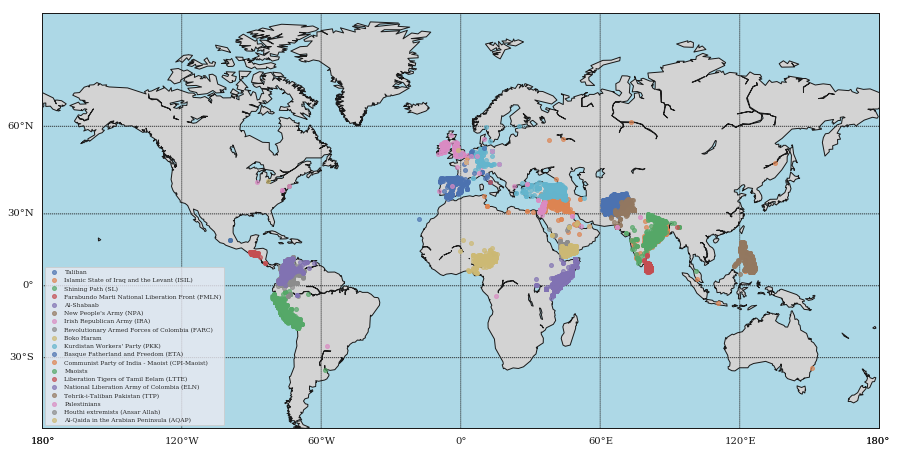

In [15]:
plt.figure(figsize=(15,8))
# miller projection
m = Basemap(projection='mill',llcrnrlat=-55,urcrnrlat=85, llcrnrlon=-180,\
            urcrnrlon=180,lat_ts=20,resolution='c')
# plot coastlines, draw label meridians and parallels.
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])
# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgrey',lake_color='lightblue')

for i, tgroup in enumerate(terror_groups_20):
    x, y = m(list(df[df['gname'] == tgroup]['longitude'].astype("float")),\
            (list(df[df['gname'] == tgroup]['latitude'].astype("float"))))
    points = m.plot(x, y, "o", markersize = 4, label = tgroup, alpha = .7)

plt.legend(loc ='lower left', prop= {'size':6})    
plt.show()

In [16]:
import plotly
#plotly.tools.set_credentials_file(username='hanzhang.ufl', api_key='')
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot, init_notebook_mode

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

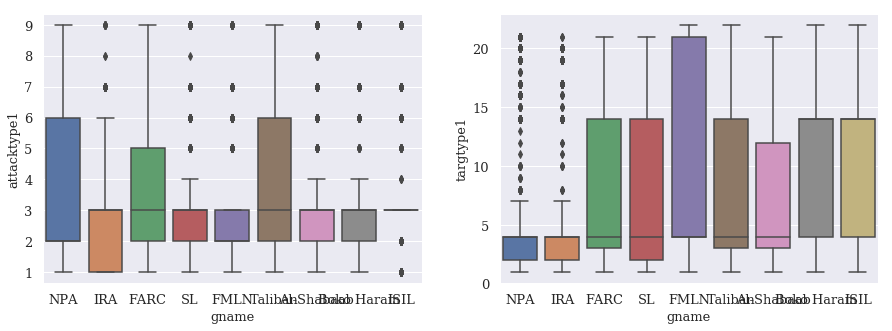

In [17]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
g = sns.boxplot(y='attacktype1', x='gname',data = terror_10,ax=ax[0])
plt.xticks(rotation=0)

g = sns.boxplot(y='targtype1', x='gname',data = terror_10,ax=ax[1])
plt.xticks(rotation=0)

In [18]:
# terrorist attack casualities by group # terrorist attack properties loss by target
group_casualities = np.asarray(terror_10.groupby('gname')['casualities'].sum())
group_prop = np.asarray(terror_10.groupby('gname')['propvalue'].sum())

group_categories = terror_10.groupby('gname')['casualities'].sum().index
group_count = np.asarray(terror_10.groupby('gname').count()['propvalue'])

group_cp = pd.DataFrame(({'casulaities':np.log1p(group_casualities), 'propvalue':np.log1p(group_prop),\
                          'count':(group_count)}),index=group_categories)

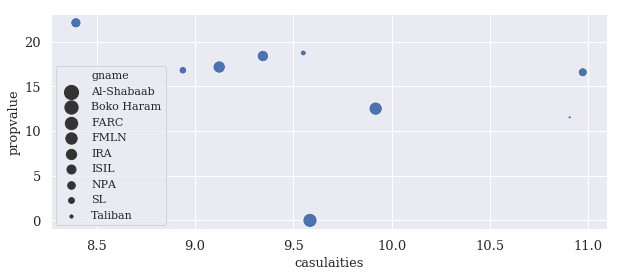

In [19]:
plt.figure(figsize=(10,4))
sns.scatterplot(x="casulaities", y="propvalue", size=group_categories,
                sizes=(10, 200),data=group_cp, palette="pastel")

Even though there are over 3000 terrorist groups, a lot of them are not active and only have less than 5 records. We will drop those groups and only care about the active groups. 

In [20]:
from collections import Counter
group_count = Counter(df['gname'])
# Remove groups with less than 5 attacks 
active_groups = [group for group, counter in group_count.items() if counter >= 5]
# Remove 'Unknown'
active_groups.remove('Unknown')

### Target 

In [21]:
# terrorist attack casualities by target
target_casualities = np.asarray(df.groupby('targtype1_txt')['casualities'].sum())
target_yaxis = np.log10(target_casualities)
# terrorist attack properties loss by target
target_prop = np.asarray(df.groupby('targtype1_txt')['propvalue'].sum())
target_xaxis = np.log10(target_prop)

target_categories = df.groupby('targtype1_txt')['casualities'].sum().index
target_count = np.asarray(df.groupby('targtype1_txt').count()['eventid'])

In [22]:
data = [go.Scatter(
        x = target_prop,
        y = target_casualities,
        text = target_categories,
        mode = 'markers',
        hoverinfo = 'text',
        marker = dict(
            size = target_count/400.0,
            opacity = 0.9,
            color = 'rgb(240, 140, 45)')
        )]

layout = go.Layout(
         title = 'Terrorist Attacks by Target (1970-2017)',
         xaxis = dict(
             title = 'Value of Property Damage',
             type = 'log',
             range = [5, 10],
             tickmode = 'auto',
             nticks = 2,
             showline = True,
             showgrid = False
         ),
         yaxis = dict(
             title = 'Casualities (nkill + nwound)',
             type = 'log',
             range = [3, 6],
             tickmode = 'auto',
             nticks = 4,
             showline = True,
             showgrid = False)
         )

annotations = []
for i in range(0, 22):
    annotations.append(dict(x=target_xaxis[i], y=target_yaxis[i],
                            xanchor='middle', yanchor='top',
                            text=target_categories[i], showarrow=False))
layout['annotations'] = annotations

figure = dict(data = data, layout = layout)
py.iplot(figure)
#figure

Private citizens & Property has the most influence and the most frequent target. 

 __Motivation of Attacks__ 

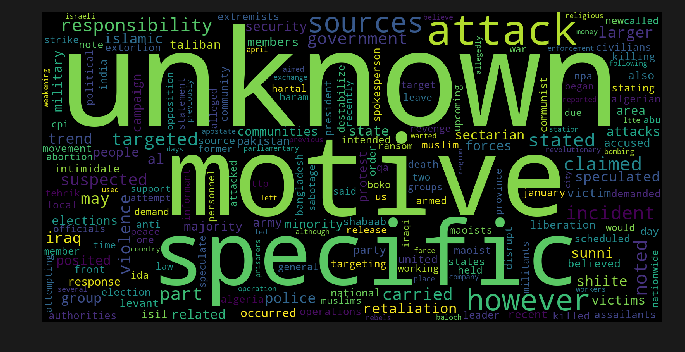

In [23]:
text_motive = df['motive'].dropna()

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
stopwords_en = stopwords.words('english')

def text_process(mess):
    word=nltk.word_tokenize(mess)
    new_word=[w for w in word if w not in stopwords_en and w.isalpha()]
    return new_word 
def word_freq(s):
    txt = s.str.lower().str.replace(r'\W+', ' ').str.cat(sep=' ')  
    words = text_process(txt)
    words_dist = nltk.FreqDist(w for w in words) 
    return words_dist

def plot_cloud(words_dist,size):
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black').generate_from_frequencies(words_dist)
    fig = plt.figure(figsize=size, facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

words_dist=word_freq(text_motive)
plot_cloud(words_dist,size = (15,5))

### [Feature Engineer](https://machinelearningmastery.com/an-introduction-to-feature-selection/) 
Data reduction is performed on the terrorism data by
selecting the most informative attributes without lose any
critical information for classification. Features that are highly correlated with other features or irrelevant to the terror groups are dropped. 

In [24]:
df_select = df.drop(columns=dropcol)
df_select = df_select[df_select['gname'].isin(active_groups)]
df_select.shape

(94871, 59)

In [25]:
cat_col = df_select.select_dtypes(include=[np.object])
num_col = df_select.select_dtypes(include=[np.number])
num_col = num_col.fillna(0)
#cat_col.columns num_col.columns

In [26]:
# drop correlated features #f = plt.figure(figsize=(40, 40)) sns.heatmap(data.corr(),annot=True)
num_col = num_col.drop(columns=['eventid','iday','imonth','latitude','longitude','targsubtype1',\
            'nkill','nkillus','nwound','INT_IDEO','INT_LOG'])

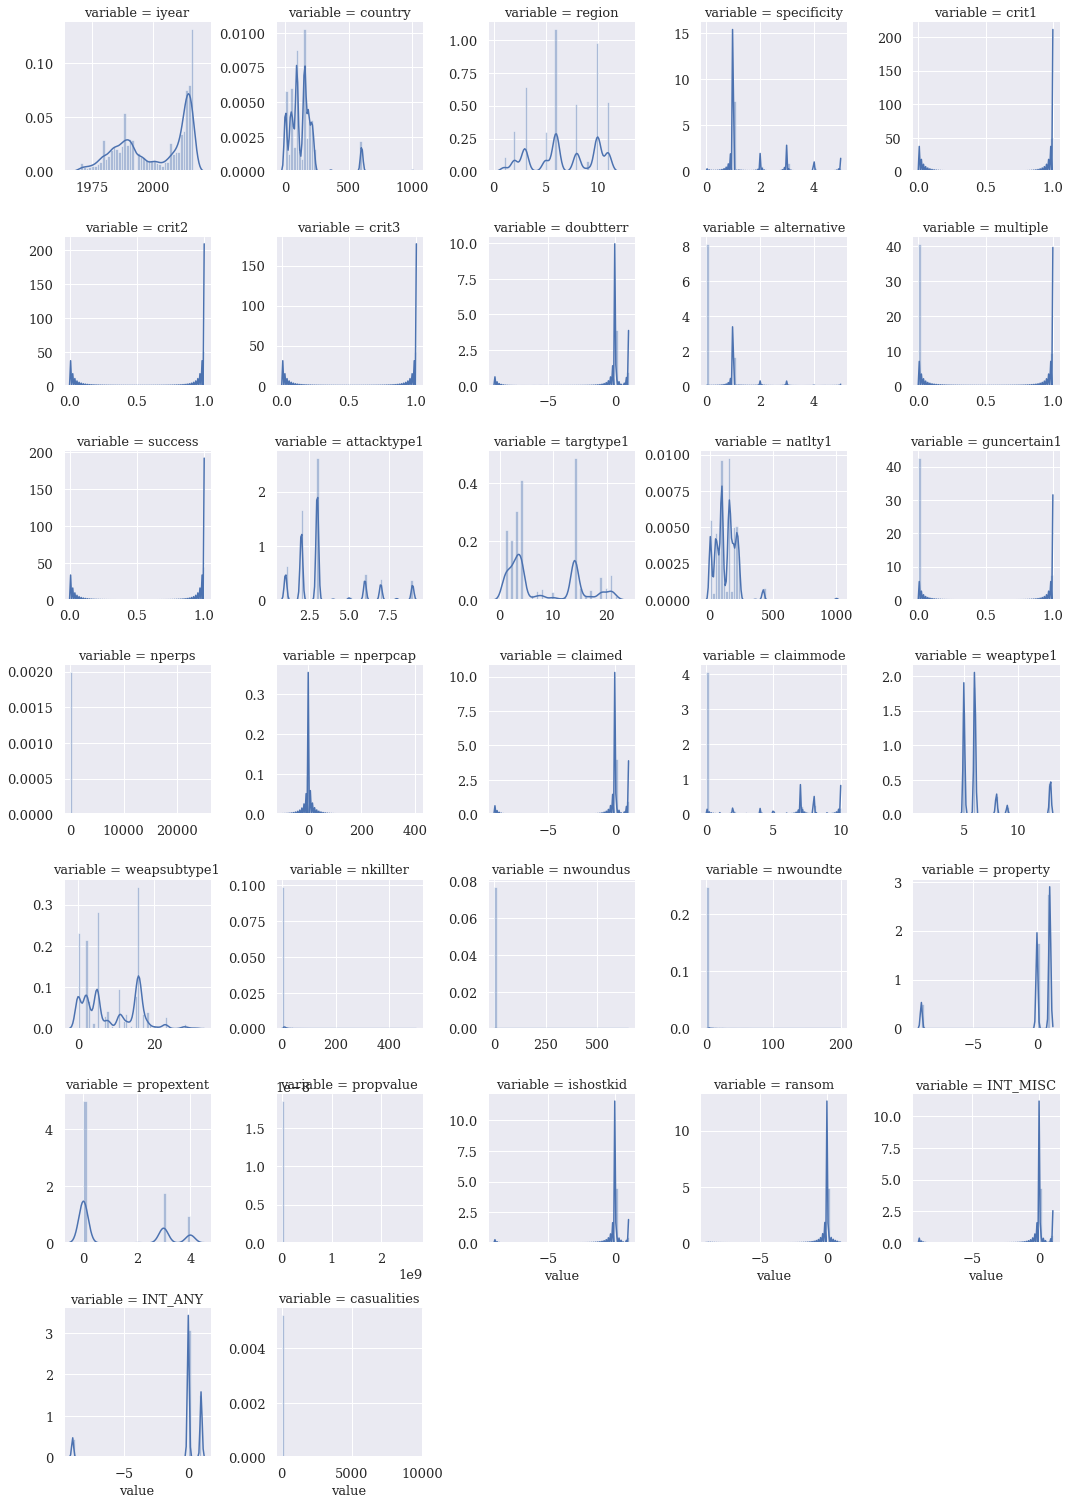

In [27]:
## visualize the distribution again
temp = pd.melt(num_col, value_vars=num_col.columns)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , height=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()

In [28]:
df_select = df_select.drop(columns=['eventid','iday','imonth','latitude','longitude','targsubtype1',\
            'nkill','nkillus','nwound','INT_IDEO','INT_LOG'])

df_select.to_csv('df_select.csv',index = False)

In [33]:
df_test = df.drop(columns=dropcol)
test = df_test[df_test['gname'] == 'Unknown']
test = test.drop(columns=['eventid','iday','imonth','latitude','longitude','targsubtype1',\
            'nkill','nkillus','nwound','INT_IDEO','INT_LOG'])
test.to_csv('test.csv',index=False)

Okay, we have done the exploratory analysis and feature engineering, we have 32 numeric features and 16 text varibles. We find location, time, attacktypes, targetypes, weaptypes are important characters of each individual group. Now go to GTD_model.ipynb for the classification modelling prediction.   